# Eeltöötlus (õige ICU - ilma fallbackita)

Faili laadimine: 

[OpenSanctions Datasets Default](https://www.opensanctions.org/datasets/default/)
<br>Targets as simplified CSV
<br>targets.simple.csv
<br>Last processed: 2025-04-07 12:54:33
<br>Last change:	2025-04-07

In [48]:
#import pandas as pd

#fail = pd.read_csv("targets.simple.csv", sep=",", low_memory=False)

In [49]:
fail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206731 entries, 0 to 1206730
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1206731 non-null  object
 1   schema       1206731 non-null  object
 2   name         1206729 non-null  object
 3   aliases      391829 non-null   object
 4   birth_date   478120 non-null   object
 5   countries    1088778 non-null  object
 6   addresses    256369 non-null   object
 7   identifiers  729155 non-null   object
 8   sanctions    299104 non-null   object
 9   phones       11538 non-null    object
 10  emails       49184 non-null    object
 11  dataset      1206731 non-null  object
 12  first_seen   1206731 non-null  object
 13  last_seen    1206731 non-null  object
 14  last_change  1206731 non-null  object
dtypes: object(15)
memory usage: 138.1+ MB


Algses andmefailis oli kokku 1 206 731 kirjet, millest valiti edasiseks töötlemiseks need, mille skeemitüübiks on Person ning millel on olemas vähemalt üks väärtus veerus aliases, st isikunimel esineb alternatiivne kuju. Alles jäeti veerud id, name ja aliases, mille alusel konstrueeritakse nimede paarid.

In [50]:
df_person = (
    fail.loc[(fail['schema'] == 'Person') & (fail['aliases'].notna()), ['id', 'name', 'aliases']]
      .rename(columns={'name': 'name_original', 'aliases': 'aliases_original'})
)

df_person.info()
df_person.head()

<class 'pandas.core.frame.DataFrame'>
Index: 338618 entries, 6 to 1206725
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                338618 non-null  object
 1   name_original     338618 non-null  object
 2   aliases_original  338618 non-null  object
dtypes: object(3)
memory usage: 10.3+ MB


,id,name_original,aliases_original
6,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI..."
7,NK-22JRrAHhpxzN8wN5pP6EGo,YASIN M HUSSAIN,Yasin M. Hussain
9,NK-22KNpaKJL84d8wpFudvLjN,Chanturiia Irakli,CHANTURIA IRAKLI;CHANTURIA IRAKLII;Чантурія Ір...
14,NK-22c6upVtxbVMhbZb3Z6dn6,Starovoitov Stanislav Yuriiovych,Starovoitov Stanislav;Starovoitov Stas;Старово...
16,NK-22j9bR6whUf6FPp6KcwzcW,Anthony Bamonte,ANTHONY BAMONTE


Et tulemused oleksid võrreldavad OpenSanctionsi normaliseerimisstrateegiatega, rakendati nimeväljadele sarnaseid puhastus- ja ühtlustamismeetodeid. Selleks kasutati väärtuste teisendamiseks stringideks teegi normality funktsiooni stringify() ning ohtlike ja mittetrükitavate sümbolite eemaldamiseks funktsiooni remove_unsafe_chars(), mille järel teisendati väärtused tõstutundetuse tagamiseks väiketähtedeks

In [51]:
!pip install normality

In [52]:
from normality import stringify
from normality.cleaning import remove_unsafe_chars

def clean_text(value):
    text = stringify(value)
    if text is None:
        return None
    text = remove_unsafe_chars(text)
    return text.lower()

In [53]:
df_person['name_clean'] = df_person['name_original'].apply(clean_text)
df_person['aliases_clean'] = df_person['aliases_original'].apply(clean_text)

df_person_clean=df_person

df_person_clean.info()
df_person_clean.head()

<class 'pandas.core.frame.DataFrame'>
Index: 338618 entries, 6 to 1206725
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                338618 non-null  object
 1   name_original     338618 non-null  object
 2   aliases_original  338618 non-null  object
 3   name_clean        338618 non-null  object
 4   aliases_clean     338618 non-null  object
dtypes: object(5)
memory usage: 15.5+ MB


,id,name_original,aliases_original,name_clean,aliases_clean
6,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,"kuajien, michael;michael kuajian;michael kuaji..."
7,NK-22JRrAHhpxzN8wN5pP6EGo,YASIN M HUSSAIN,Yasin M. Hussain,yasin m hussain,yasin m. hussain
9,NK-22KNpaKJL84d8wpFudvLjN,Chanturiia Irakli,CHANTURIA IRAKLI;CHANTURIA IRAKLII;Чантурія Ір...,chanturiia irakli,chanturia irakli;chanturia iraklii;чантурія ір...
14,NK-22c6upVtxbVMhbZb3Z6dn6,Starovoitov Stanislav Yuriiovych,Starovoitov Stanislav;Starovoitov Stas;Старово...,starovoitov stanislav yuriiovych,starovoitov stanislav;starovoitov stas;старово...
16,NK-22j9bR6whUf6FPp6KcwzcW,Anthony Bamonte,ANTHONY BAMONTE,anthony bamonte,anthony bamonte


Kuna aliases veerg sisaldab nimevariantide loendit, oli vajalik iga aliase eraldamine iseseisvaks kirjeks. Selleks jagati aliased eraldaja (semikoolon, püstkriips või kaldkriips) järgi alamloenditeks ning rakendati Pythoni explode-operatsiooni, mille tulemusel asetati iga alias eraldi reale. Edasi eemaldati tühikud ning kõrvaldati tühjad väärtused.

In [54]:
df_person_clean['aliases_clean'] = df_person_clean['aliases_clean'].str.strip().str.split(r'[;|\||/]')
df_person_clean = df_person_clean.explode('aliases_clean')
df_person_clean['alias_clean'] = df_person_clean['aliases_clean'].str.strip()
df_person_explode = df_person_clean[df_person_clean['alias_clean'] != '']
df_person_exploded = df_person_explode[['id', 'name_original', 'aliases_original', 'name_clean', 'alias_clean']].copy()
df_person_exploded.rename(columns={'id': 'id_original'}, inplace=True)
df_person_exploded['id'] = range(1, len(df_person_exploded) + 1)
df_exploded_id = df_person_exploded[['id', 'id_original', 'name_original', 'aliases_original', 'name_clean', 'alias_clean']]

df_exploded_id.head()

,id,id_original,name_original,aliases_original,name_clean,alias_clean
6,1,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,"kuajien, michael"
6,2,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,michael kuajian
6,3,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,michael kuajien
6,4,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,michael kuajien duer mayok
6,5,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,michael kuajian


In [55]:
df_exploded_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1119330 entries, 6 to 1206725
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   id                1119330 non-null  int64 
 1   id_original       1119330 non-null  object
 2   name_original     1119330 non-null  object
 3   aliases_original  1119330 non-null  object
 4   name_clean        1119330 non-null  object
 5   alias_clean       1119330 non-null  object
dtypes: int64(1), object(5)
memory usage: 59.8+ MB


Kuna analüüs keskendub erinevates kirjutussüsteemides esinevatele nimevariantidele, jäeti alles ainult need read, kus ühe nimekuju tähestikuna tuvastati ladina ja teise puhul kirillitsa.

In [56]:
!pip install matplotlib

In [57]:
import unicodedata
from collections import Counter
import matplotlib.pyplot as plt

def detect_character_scripts(text):
    detected_scripts = set()
    for char in str(text):
        try:
            script = unicodedata.name(char).split()[0]
        except ValueError:
            script = "UNKNOWN"
        detected_scripts.add(script)
    return detected_scripts

df_exploded_id=df_exploded_id.copy()

df_exploded_id['name_scripts'] = df_exploded_id['name_clean'].apply(detect_character_scripts)
df_exploded_id['alias_scripts'] = df_exploded_id['alias_clean'].apply(detect_character_scripts)

combined_scripts = df_exploded_id['name_scripts'].tolist() + df_exploded_id['alias_scripts'].tolist()
flat_scripts = [script for scripts_set in combined_scripts for script in scripts_set]
script_counts = Counter(flat_scripts)

# kirjavahemärgid ja muud mitte-tähestikulised
exclude_scripts = {'SPACE', 'COMMA', 'HYPHEN-MINUS', 'FULL', 'APOSTROPHE', 'MIDDLE', 'RIGHT', 'LEFT'}
filtered_counts = Counter({k: v for k, v in script_counts.items() if k not in exclude_scripts})

In [58]:
df_exploded_id.info()
df_exploded_id.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1119330 entries, 6 to 1206725
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   id                1119330 non-null  int64 
 1   id_original       1119330 non-null  object
 2   name_original     1119330 non-null  object
 3   aliases_original  1119330 non-null  object
 4   name_clean        1119330 non-null  object
 5   alias_clean       1119330 non-null  object
 6   name_scripts      1119330 non-null  object
 7   alias_scripts     1119330 non-null  object
dtypes: int64(1), object(7)
memory usage: 76.9+ MB


,id,id_original,name_original,aliases_original,name_clean,alias_clean,name_scripts,alias_scripts
6,1,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,"kuajien, michael","{SPACE, LATIN}","{SPACE, COMMA, LATIN}"
6,2,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,michael kuajian,"{SPACE, LATIN}","{SPACE, LATIN}"
6,3,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,michael kuajien,"{SPACE, LATIN}","{SPACE, LATIN}"
6,4,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,michael kuajien duer mayok,"{SPACE, LATIN}","{SPACE, LATIN}"
6,5,NK-22HtK7WrxZ2sU3rmhz6PuZ,Michael Kuajien,"KUAJIEN, Michael;MICHAEL KUAJIAN;MICHAEL KUAJI...",michael kuajien,michael kuajian,"{SPACE, LATIN}","{SPACE, LATIN}"


Top 10 tähestikku

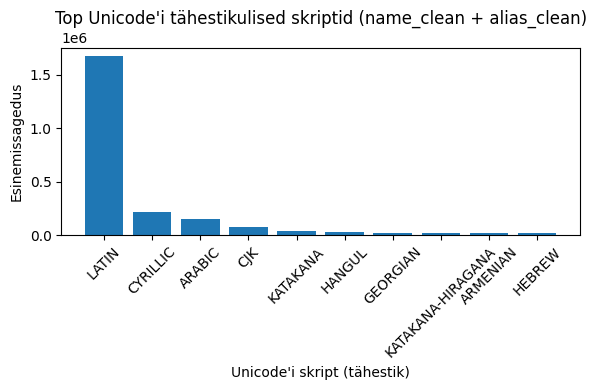

In [59]:
top_scripts = filtered_counts.most_common(10)
labels, values = zip(*top_scripts)

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.title("Top Unicode'i tähestikulised skriptid (name_clean + alias_clean)")
plt.xlabel("Unicode'i skript (tähestik)")
plt.ylabel("Esinemissagedus")
plt.tight_layout()
plt.show()

Alles jäeti need, kus domineerivad skriptid on kas LATIN või CYRILLIC ja skriptid on erinevad (nt üks LATIN, teine CYRILLIC)

In [60]:
def detect_character_scripts(text):
    script_counts = Counter()
    for char in str(text):
        try:
            script = unicodedata.name(char).split()[0]
        except ValueError:
            script = "UNKNOWN"
        script_counts[script] += 1
    return script_counts

def dominant_script(script_counts):
    for script, count in script_counts.most_common():
        if script in {"LATIN", "CYRILLIC"}:
            return script
    return "OTHER"

df_exploded_id = df_exploded_id.copy()
df_exploded_id["name_script_counts"] = df_exploded_id["name_clean"].apply(detect_character_scripts)
df_exploded_id["alias_script_counts"] = df_exploded_id["alias_clean"].apply(detect_character_scripts)

df_exploded_id["name_script"] = df_exploded_id["name_script_counts"].apply(dominant_script)
df_exploded_id["alias_script"] = df_exploded_id["alias_script_counts"].apply(dominant_script)

df_latin_to_cyrillic = df_exploded_id[
    (df_exploded_id["name_script"] == "LATIN") &
    (df_exploded_id["alias_script"] == "CYRILLIC")
]

In [61]:
df_latin_to_cyrillic.info()
df_latin_to_cyrillic.head()

<class 'pandas.core.frame.DataFrame'>
Index: 200754 entries, 9 to 1178109
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   200754 non-null  int64 
 1   id_original          200754 non-null  object
 2   name_original        200754 non-null  object
 3   aliases_original     200754 non-null  object
 4   name_clean           200754 non-null  object
 5   alias_clean          200754 non-null  object
 6   name_scripts         200754 non-null  object
 7   alias_scripts        200754 non-null  object
 8   name_script_counts   200754 non-null  object
 9   alias_script_counts  200754 non-null  object
 10  name_script          200754 non-null  object
 11  alias_script         200754 non-null  object
dtypes: int64(1), object(11)
memory usage: 19.9+ MB


,id,id_original,name_original,aliases_original,name_clean,alias_clean,name_scripts,alias_scripts,name_script_counts,alias_script_counts,name_script,alias_script
9,10,NK-22KNpaKJL84d8wpFudvLjN,Chanturiia Irakli,CHANTURIA IRAKLI;CHANTURIA IRAKLII;Чантурія Ір...,chanturiia irakli,чантурія іраклі,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 16, 'SPACE': 1}","{'CYRILLIC': 14, 'SPACE': 1}",LATIN,CYRILLIC
14,13,NK-22c6upVtxbVMhbZb3Z6dn6,Starovoitov Stanislav Yuriiovych,Starovoitov Stanislav;Starovoitov Stas;Старово...,starovoitov stanislav yuriiovych,старовойтов станислав юрьевич,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 30, 'SPACE': 2}","{'CYRILLIC': 27, 'SPACE': 2}",LATIN,CYRILLIC
14,14,NK-22c6upVtxbVMhbZb3Z6dn6,Starovoitov Stanislav Yuriiovych,Starovoitov Stanislav;Starovoitov Stas;Старово...,starovoitov stanislav yuriiovych,старовойтов станіслав юрійович,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 30, 'SPACE': 2}","{'CYRILLIC': 28, 'SPACE': 2}",LATIN,CYRILLIC
14,15,NK-22c6upVtxbVMhbZb3Z6dn6,Starovoitov Stanislav Yuriiovych,Starovoitov Stanislav;Starovoitov Stas;Старово...,starovoitov stanislav yuriiovych,старовойтов стас,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 30, 'SPACE': 2}","{'CYRILLIC': 15, 'SPACE': 1}",LATIN,CYRILLIC
17,17,NK-22sRNHw9xqUbicAXF4i7BP,Maslov Alexey Viktorovich,Маслов Алексей Викторович,maslov alexey viktorovich,маслов алексей викторович,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 23, 'SPACE': 2}","{'CYRILLIC': 23, 'SPACE': 2}",LATIN,CYRILLIC


Skriptide loendamine:

In [62]:
name_script_counts = df_latin_to_cyrillic['name_script'].value_counts()
alias_script_counts = df_latin_to_cyrillic['alias_script'].value_counts()

print("Skriptide jaotus veerus name_script:")
print(name_script_counts)

print("\nSkriptide jaotus veerus alias_script:")
print(alias_script_counts)

Skriptide jaotus veerus name_script:
name_script
LATIN    200754
Name: count, dtype: int64

Skriptide jaotus veerus alias_script:
alias_script
CYRILLIC    200754
Name: count, dtype: int64


Leiti kõik kirjed, mille alias väli sisaldas üksnes lubatud sümboleid. Lubatud tähemärkide hulka kuulusid kirillitsa tähemärgid Unicode’i plokkidest Cyrillic (U+0400-U+04FF) ja Cyrillic Supplement (U+0500-U+052F), kirjavahemärgid sümbolid plokist Basic Latin (U+0020-U+007E) ning tühikuna üksnes U+0020. Viimase puhul kontrolliti, et tegemist oli ainsa märgiga Unicode’i kategooriast Zs.

In [63]:
def find_unique_spaces(dataframe, columns):
    unique_spaces = set()
    for column in columns:
        for value in dataframe[column].dropna():
            for char in value:
                if unicodedata.category(char) == "Zs":
                    unique_spaces.add(char)
    return {char: f"U+{ord(char):04X}" for char in unique_spaces}

unique_spaces = find_unique_spaces(df_latin_to_cyrillic, ['name_clean', 'alias_clean'])

for space, unicode_code in unique_spaces.items():
    print(f"'{space}' (Unicode: {unicode_code}, Name: {unicodedata.name(space)})")

' ' (Unicode: U+0020, Name: SPACE)


In [64]:
import re

# lubatud tähemärgid
ALLOWED_CHARS_RE = re.compile(r'^[\u0400-\u052F\u0020-\u007E]+$')

df_allowed_symbols = df_latin_to_cyrillic[
    df_latin_to_cyrillic['alias_clean'].apply(lambda x: bool(ALLOWED_CHARS_RE.fullmatch(x)))
].copy()

In [65]:
df_allowed_symbols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199638 entries, 9 to 1178109
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   199638 non-null  int64 
 1   id_original          199638 non-null  object
 2   name_original        199638 non-null  object
 3   aliases_original     199638 non-null  object
 4   name_clean           199638 non-null  object
 5   alias_clean          199638 non-null  object
 6   name_scripts         199638 non-null  object
 7   alias_scripts        199638 non-null  object
 8   name_script_counts   199638 non-null  object
 9   alias_script_counts  199638 non-null  object
 10  name_script          199638 non-null  object
 11  alias_script         199638 non-null  object
dtypes: int64(1), object(11)
memory usage: 19.8+ MB


Sulgudes ja nurksulgudes asuva teksti eemaldamiseks rakendati OpenSanctionsi praktikast tuntud normality funktsiooni clean_brackets().

In [66]:
name_with_parentheses = df_allowed_symbols[df_allowed_symbols['name_clean'].str.contains(r"\(.*?\)", regex=True)]
print(f"Sulge sisaldavaid ridu veerus name_clean: {len(name_with_parentheses):,}")

alias_with_parentheses = df_allowed_symbols[df_allowed_symbols['alias_clean'].str.contains(r"\(.*?\)", regex=True)]
print(f"Sulge sisaldavaid ridu veerus alias_clean: {len(alias_with_parentheses):,}")

Sulge sisaldavaid ridu veerus name_clean: 134
Sulge sisaldavaid ridu veerus alias_clean: 178


Üksikud sulud tekkisid explode() tagajärjel. OpenSanctions eeskujul eemaldame sulud ja sulgude sisu, asendame väärtusega " " (tekivad topelttühikud). Rakendati topelttühikute eemaldamist ja trimmimist:

In [67]:
BRACKETED = re.compile(r"(\([^\(\)]*\)|\[[^\[\]]*\])")  # (midagi) või [midagi]
MULTISPACE = re.compile(r"\s+")  # mitu tühikut

WS = " "

def clean_brackets(text: str) -> str:
    text = BRACKETED.sub(WS, text)         # eemalda sulud
    text = re.sub(r"[()\[\]]", WS, text)   # kuna explode tulemusel jäid üksikud sulud, on vaja need eemaldada
    text = MULTISPACE.sub(WS, text)        # eemalda topelttühikud
    return text.strip()                    # eemalda ääretühikud

df_no_brackets = df_allowed_symbols.copy()

In [68]:
df_no_brackets['name_clean'] = df_no_brackets['name_clean'].apply(clean_brackets)
df_no_brackets['alias_clean'] = df_no_brackets['alias_clean'].apply(clean_brackets)

In [69]:
df_no_brackets[df_no_brackets['name_clean'].str.contains(r"[()\[\]]", na=False)].head()

,id,id_original,name_original,aliases_original,name_clean,alias_clean,name_scripts,alias_scripts,name_script_counts,alias_script_counts,name_script,alias_script


In [70]:
df_no_brackets[df_no_brackets['alias_clean'].str.contains(r"[()\[\]]", na=False)].head(10)

,id,id_original,name_original,aliases_original,name_clean,alias_clean,name_scripts,alias_scripts,name_script_counts,alias_script_counts,name_script,alias_script


Levinud nimelisandite eemaldamiseks kasutati normality funktsiooni clean_entity_prefix()

In [71]:
PREFIXES_RAW_LIST = [
    "Mr", "Ms", "Mrs", "Mister", "Miss", "Madam", "Madame", "Monsieur",
    "Honorable", "Honourable", "Mme", "Mmme", "Herr", "Hr", "Frau", "Fr",
    "The", "Fräulein", "Senor", "Senorita", "Sheik", "Sheikh", "Shaikh",
    "Sr", "Sir", "Lady", "The", "de", "of"
]
PREFIXES_RAW = "|".join(PREFIXES_RAW_LIST)
NAME_PATTERN_ = r"^\W*((%s)\.?\s+)*(?P<term>.*?)([\'’]s)?\W*$" % PREFIXES_RAW
PREFIXES = re.compile(NAME_PATTERN_, re.I | re.U)

def clean_prefix(name: str) -> str:
    match = PREFIXES.match(name)
    if match is not None:
        return match.group("term").strip()
    return name

df_no_prefix = df_no_brackets.copy()

df_no_prefix['name_final'] = df_no_prefix['name_clean'].apply(clean_brackets).apply(clean_prefix)
df_no_prefix['alias_final'] = df_no_prefix['alias_clean'].apply(clean_brackets).apply(clean_prefix)

Millised sümbolid on andmestikus:

In [72]:
col1 = 'alias_final'
col2 = 'name_final'

alias_text = ''.join(df_no_prefix[col1].dropna())
name_text = ''.join(df_no_prefix[col2].dropna())

alias_counts = Counter(alias_text)
name_counts = Counter(name_text)

alias_counts_df = pd.DataFrame(alias_counts.items(), columns=['Symbol', 'Alias_Count']).sort_values(by='Alias_Count', ascending=False)
name_counts_df = pd.DataFrame(name_counts.items(), columns=['Symbol', 'Name_Count']).sort_values(by='Name_Count', ascending=False)

print("\nName_final sümbolite sagedustabel:")
print(name_counts_df)

print("Alias_final sümbolite sagedustabel:")
print(alias_counts_df)


Name_final sümbolite sagedustabel:
    Symbol  Name_Count
2        a      432359
7        i      329319
8               270503
16       e      259448
12       o      243758
..     ...         ...
152      –           1
150      ´           1
141      ệ           1
143      ṣ           1
169      г           1

[173 rows x 2 columns]
Alias_final sümbolite sagedustabel:
    Symbol  Alias_Count
1        а       420831
15       и       317048
8                298976
12       о       267441
2        н       242315
..     ...          ...
99       ѐ            1
111      q            1
112      $            1
113      ӱ            1
114      ҥ            1

[115 rows x 2 columns]


# Nimekomponentide jaotus

Uuriti name ja alias väljade sõnalist struktuuri, analüüsides nende nimeosade arvu. Tulemused näitasid, et valdav osa nimekujudest koosnes kahest kuni kolmest komponendist, kuid leidus ka erindeid, kus nimede pikkus ulatus 5 kuni 18 komponendini.

In [73]:
df_script_filtered = df_no_prefix.copy()

df_script_filtered['name_tokens'] = df_script_filtered['name_clean'].str.split().apply(len)
df_script_filtered['alias_tokens'] = df_script_filtered['alias_clean'].str.split().apply(len)

import seaborn as sns

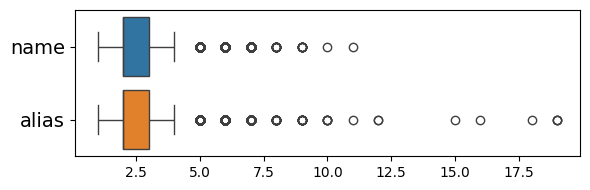

In [74]:
plt.figure(figsize=(6, 2))
sns.boxplot(data=df_script_filtered[['name_tokens', 'alias_tokens']], orient='h')

plt.yticks(ticks=[0, 1], labels=["name", "alias"], fontsize=14)
plt.tight_layout()
plt.show()

In [75]:
def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return len(outliers)

total_rows = len(df_script_filtered)

name_outliers = count_outliers(df_script_filtered['name_tokens'])
alias_outliers = count_outliers(df_script_filtered['alias_tokens'])

name_outlier_pct = name_outliers / total_rows * 100
alias_outlier_pct = alias_outliers / total_rows * 100

print(f"Name erindid: {name_outliers} ({name_outlier_pct:.2f}%)")
print(f"Alias erindid: {alias_outliers} ({alias_outlier_pct:.2f}%)")
print(f"Kokku unikaalseid ridu: {total_rows}")


Name erindid: 1512 (0.76%)
Alias erindid: 1105 (0.55%)
Kokku unikaalseid ridu: 199638


Erindid moodustasid vähem kui ühe protsendi andmestikust ning nad eemaldati.

In [76]:
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_script_filtered = df_script_filtered.copy()

df_script_filtered['name_tokens'] = df_script_filtered['name_clean'].str.split().apply(len)
df_script_filtered['alias_tokens'] = df_script_filtered['alias_clean'].str.split().apply(len)

df_script_no_outliers = remove_outliers_iqr(df_script_filtered, 'name_tokens')
df_script_no_outliers = remove_outliers_iqr(df_script_no_outliers, 'alias_tokens')

print(f"Pärast erindite eemaldamist: {len(df_script_no_outliers):,} rida")

Pärast erindite eemaldamist: 197,741 rida


In [77]:
df_script_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197741 entries, 9 to 1178109
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   197741 non-null  int64 
 1   id_original          197741 non-null  object
 2   name_original        197741 non-null  object
 3   aliases_original     197741 non-null  object
 4   name_clean           197741 non-null  object
 5   alias_clean          197741 non-null  object
 6   name_scripts         197741 non-null  object
 7   alias_scripts        197741 non-null  object
 8   name_script_counts   197741 non-null  object
 9   alias_script_counts  197741 non-null  object
 10  name_script          197741 non-null  object
 11  alias_script         197741 non-null  object
 12  name_final           197741 non-null  object
 13  alias_final          197741 non-null  object
 14  name_tokens          197741 non-null  int64 
 15  alias_tokens         197741 non-null  

In [78]:
df_script_no_outliers.sample(10)

,id,id_original,name_original,aliases_original,name_clean,alias_clean,name_scripts,alias_scripts,name_script_counts,alias_script_counts,name_script,alias_script,name_final,alias_final,name_tokens,alias_tokens
402506,920202,Q7931810,Vincent Garcia,Vincent J. Garcia;Винсент Гарсиа;فنسنت غارسيا,vincent garcia,винсент гарсиа,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 13, 'SPACE': 1}","{'CYRILLIC': 13, 'SPACE': 1}",LATIN,CYRILLIC,vincent garcia,винсент гарсиа,2,2
125992,201213,Q120852454,Sergeev Fedor Mihajlovich,Fedor Mihajlovich Sergeev;Сергеев Федор Михайл...,sergeev fedor mihajlovich,сергеєв федір михайлович,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 23, 'SPACE': 2}","{'CYRILLIC': 22, 'SPACE': 2}",LATIN,CYRILLIC,sergeev fedor mihajlovich,сергеєв федір михайлович,3,3
663537,1049146,ge-dec-d3627268c7907ba195ad2b203cfe738b198354b1,Gurami Mikatsadze,Гурам Микацадзе;غورامي ميكاتسادي;გურამი მიქაცაძე,gurami mikatsadze,гурам микацадзе,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 16, 'SPACE': 1}","{'CYRILLIC': 14, 'SPACE': 1}",LATIN,CYRILLIC,gurami mikatsadze,гурам микацадзе,2,2
129452,212432,Q12112307,Olena Kondratiuk,Jelena Kondratjuk;Jelena Konstantinowna Kondra...,olena kondratiuk,кондратюк олена костянтинівна,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 15, 'SPACE': 1}","{'CYRILLIC': 27, 'SPACE': 2}",LATIN,CYRILLIC,olena kondratiuk,кондратюк олена костянтинівна,2,3
273646,631175,Q4401119,Rusu Ihor Mykhailovych,Rusu Igor;ИГОРЬ МИХАЙЛОВИЧ РУСУ;Игорь Михайлов...,rusu ihor mykhailovych,"русу, игорь михайлович","{SPACE, LATIN}","{SPACE, CYRILLIC, COMMA}","{'LATIN': 20, 'SPACE': 2}","{'CYRILLIC': 19, 'COMMA': 1, 'SPACE': 2}",LATIN,CYRILLIC,rusu ihor mykhailovych,"русу, игорь михайлович",3,3
171078,280322,Q152335,Laszlo Solyom,Laszlo Sólyom;Laszló Sólyom;Lászlo Solyom;Lász...,laszlo solyom,ласло шојом,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 12, 'SPACE': 1}","{'CYRILLIC': 10, 'SPACE': 1}",LATIN,CYRILLIC,laszlo solyom,ласло шојом,2,2
126611,203154,Q120853183,Nikitenko Andrej Ivanovich,Andrej Ivanovich Nikitenko;Никитенко Андрей Ив...,nikitenko andrej ivanovich,никитенко андрій іванович,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 24, 'SPACE': 2}","{'CYRILLIC': 23, 'SPACE': 2}",LATIN,CYRILLIC,nikitenko andrej ivanovich,никитенко андрій іванович,3,3
182517,314171,Q163286,Hyu Qrant,Hju Grantas;Hjū Grānts;Hugh Grant;Hugh John Mu...,hyu qrant,грант хью,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 8, 'SPACE': 1}","{'CYRILLIC': 8, 'SPACE': 1}",LATIN,CYRILLIC,hyu qrant,грант хью,2,2
270192,605287,Q4206772,Vladimir Kabysjev,Vladimir Kabyshev;Vladimir Terentevitsj Kabisj...,vladimir kabysjev,владимир терентьевич кабышев,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 16, 'SPACE': 1}","{'CYRILLIC': 26, 'SPACE': 2}",LATIN,CYRILLIC,vladimir kabysjev,владимир терентьевич кабышев,2,3
654254,1021307,ge-dec-3c18fafdd6d55ccee54900203a50b63f59253639,Leri Bochorishvili,Лери Бочоришвили;ليري بوتشوريشفیلي;ლერი ბოჭორი...,leri bochorishvili,лери бочоришвили,"{SPACE, LATIN}","{SPACE, CYRILLIC}","{'LATIN': 17, 'SPACE': 1}","{'CYRILLIC': 15, 'SPACE': 1}",LATIN,CYRILLIC,leri bochorishvili,лери бочоришвили,2,2


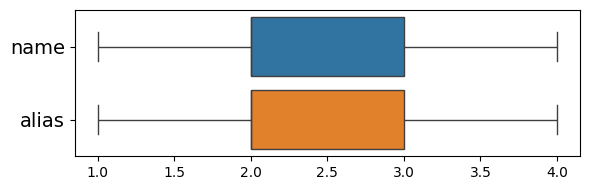

In [79]:
plt.figure(figsize=(6, 2))
sns.boxplot(data=df_script_no_outliers[['name_tokens', 'alias_tokens']], orient='h')

plt.yticks(ticks=[0, 1], labels=["name", "alias"], fontsize=14)
plt.tight_layout()
plt.show()

Puhastatud andmestikus esineb kõige rohkem nimepaare, mis koosneb võrdselt kahest või võrdselt kolmest komponendist. Võrdsete komponentide arvuga nimepaare on andmestikus kokku 73,9%

In [80]:
df = df_script_no_outliers.copy()

df['name_token_count'] = df['name_final'].str.split().apply(len)
df['alias_token_count'] = df['alias_final'].str.split().apply(len)

name_suffix_pattern = re.compile(r'(itš|ich|vna|wna)$', re.IGNORECASE)
alias_suffix_pattern = re.compile(r'(ович|евич|ич|овна|евна|іч|івна|ївна|авіч|евіч|аўна|еўна)$', re.IGNORECASE)

def count_matching_tokens(text, pattern):
    if isinstance(text, str):
        return sum(bool(pattern.search(token)) for token in text.split())
    return 0

df['name_suffix_token_count'] = df['name_final'].apply(lambda x: count_matching_tokens(x, name_suffix_pattern))
df['alias_suffix_token_count'] = df['alias_final'].apply(lambda x: count_matching_tokens(x, alias_suffix_pattern))

df_filtered = df[
    df['name_token_count'].between(1, 4) &
    df['alias_token_count'].between(1, 4)
].copy()

summary = (
    df_filtered
    .groupby(['name_token_count', 'alias_token_count'])
    .agg(
        count=('name_final', 'size'),
        name_suffix_token_count=('name_suffix_token_count', 'sum'),
        alias_suffix_token_count=('alias_suffix_token_count', 'sum')
    )
    .reset_index()
)

summary['percentage'] = (summary['count'] / summary['count'].sum() * 100).round(2)
summary['name_suffix_percentage'] = (
    summary['name_suffix_token_count'] / (summary['name_token_count'] * summary['count']) * 100
).round(2)
summary['alias_suffix_percentage'] = (
    summary['alias_suffix_token_count'] / (summary['alias_token_count'] * summary['count']) * 100
).round(2)

print(summary)

    name_token_count  alias_token_count  count  name_suffix_token_count  \
0                  1                  1    506                        0   
1                  1                  2    162                        0   
2                  1                  3    144                        0   
3                  1                  4     10                        0   
4                  2                  1   2163                       14   
5                  2                  2  91351                      481   
6                  2                  3  39037                      562   
7                  2                  4    991                        0   
8                  3                  1    466                      227   
9                  3                  2   6989                     2414   
10                 3                  3  52895                    35748   
11                 3                  4    362                       33   
12                 4     

In [81]:
df_script_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197741 entries, 9 to 1178109
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   197741 non-null  int64 
 1   id_original          197741 non-null  object
 2   name_original        197741 non-null  object
 3   aliases_original     197741 non-null  object
 4   name_clean           197741 non-null  object
 5   alias_clean          197741 non-null  object
 6   name_scripts         197741 non-null  object
 7   alias_scripts        197741 non-null  object
 8   name_script_counts   197741 non-null  object
 9   alias_script_counts  197741 non-null  object
 10  name_script          197741 non-null  object
 11  alias_script         197741 non-null  object
 12  name_final           197741 non-null  object
 13  alias_final          197741 non-null  object
 14  name_tokens          197741 non-null  int64 
 15  alias_tokens         197741 non-null  

Nimelisandite tuvastamiseks ja analüüsimiseks koostati sagedustabel, mis sisaldab kõige levinumaid 1-3 tähemärgist koosnevaid järjendeid. Järjendite eraldajatena kasutati tühikuid. Andmestikus ei ilmnenud levinuid eesliiteid, mida peaks täiendavalt defineerima nimelisanditena.

In [82]:
def extract_tokens_by_length(series, lengths=(1, 2, 3, 4)):
    counter = Counter()
    for text in series.dropna():
        words = str(text).split()
        short_words = [w.lower() for w in words if len(w) in lengths]
        counter.update(short_words)
    return counter

def pad_list_to_length(lst, length):
    return lst + [None] * (length - len(lst))

name_counts = extract_tokens_by_length(df_script_no_outliers['name_final'])
alias_counts = extract_tokens_by_length(df_script_no_outliers['alias_final'])

N = 20
top_1_name_tokens = [(word, count) for word, count in name_counts.most_common() if len(word) == 1][:N]
top_2_name_tokens = [(word, count) for word, count in name_counts.most_common() if len(word) == 2][:N]
top_3_name_tokens = [(word, count) for word, count in name_counts.most_common() if len(word) == 3][:N]
top_4_name_tokens = [(word, count) for word, count in name_counts.most_common() if len(word) == 4][:N]

top_1_alias_tokens = [(word, count) for word, count in alias_counts.most_common() if len(word) == 1][:N]
top_2_alias_tokens = [(word, count) for word, count in alias_counts.most_common() if len(word) == 2][:N]
top_3_alias_tokens = [(word, count) for word, count in alias_counts.most_common() if len(word) == 3][:N]
top_4_alias_tokens = [(word, count) for word, count in alias_counts.most_common() if len(word) == 4][:N]

max_len = max(
    len(top_1_name_tokens), len(top_2_name_tokens), len(top_3_name_tokens), len(top_4_name_tokens),
    len(top_1_alias_tokens), len(top_2_alias_tokens), len(top_3_alias_tokens), len(top_4_alias_tokens)
)

data = {
    '1-kohalised (name_final)': pad_list_to_length([word for word, _ in top_1_name_tokens], max_len),
    'Sagedus 1-kohalised (name_final)': pad_list_to_length([count for _, count in top_1_name_tokens], max_len),
    '2-kohalised (name_final)': pad_list_to_length([word for word, _ in top_2_name_tokens], max_len),
    'Sagedus 2-kohalised (name_final)': pad_list_to_length([count for _, count in top_2_name_tokens], max_len),
    '3-kohalised (name_final)': pad_list_to_length([word for word, _ in top_3_name_tokens], max_len),
    'Sagedus 3-kohalised (name_final)': pad_list_to_length([count for _, count in top_3_name_tokens], max_len),
    '4-kohalised (name_final)': pad_list_to_length([word for word, _ in top_4_name_tokens], max_len),
    'Sagedus 4-kohalised (name_final)': pad_list_to_length([count for _, count in top_4_name_tokens], max_len),
    '1-kohalised (alias_final)': pad_list_to_length([word for word, _ in top_1_alias_tokens], max_len),
    'Sagedus 1-kohalised (alias_final)': pad_list_to_length([count for _, count in top_1_alias_tokens], max_len),
    '2-kohalised (alias_final)': pad_list_to_length([word for word, _ in top_2_alias_tokens], max_len),
    'Sagedus 2-kohalised (alias_final)': pad_list_to_length([count for _, count in top_2_alias_tokens], max_len),
    '3-kohalised (alias_final)': pad_list_to_length([word for word, _ in top_3_alias_tokens], max_len),
    'Sagedus 3-kohalised (alias_final)': pad_list_to_length([count for _, count in top_3_alias_tokens], max_len),
    '4-kohalised (alias_final)': pad_list_to_length([word for word, _ in top_4_alias_tokens], max_len),
    'Sagedus 4-kohalised (alias_final)': pad_list_to_length([count for _, count in top_4_alias_tokens], max_len),
}

df_top_tokens = pd.DataFrame(data)

print(df_top_tokens)

   1-kohalised (name_final)  Sagedus 1-kohalised (name_final)  \
0                         i                               199   
1                         a                                58   
2                         v                                54   
3                         y                                18   
4                         n                                14   
5                         m                                12   
6                         x                                11   
7                         s                                10   
8                         e                                10   
9                         /                                 6   
10                        o                                 5   
11                        k                                 4   
12                        z                                 4   
13                        l                                 4   
14                       

In [83]:
df_script_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197741 entries, 9 to 1178109
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   197741 non-null  int64 
 1   id_original          197741 non-null  object
 2   name_original        197741 non-null  object
 3   aliases_original     197741 non-null  object
 4   name_clean           197741 non-null  object
 5   alias_clean          197741 non-null  object
 6   name_scripts         197741 non-null  object
 7   alias_scripts        197741 non-null  object
 8   name_script_counts   197741 non-null  object
 9   alias_script_counts  197741 non-null  object
 10  name_script          197741 non-null  object
 11  alias_script         197741 non-null  object
 12  name_final           197741 non-null  object
 13  alias_final          197741 non-null  object
 14  name_tokens          197741 non-null  int64 
 15  alias_tokens         197741 non-null  

# Eksport CSV faili

In [84]:
df_script_no_outliers.to_csv("output01.csv", index=False, encoding="utf-8", sep=";")

# Konverteerimine HTML failiks 

In [85]:
!jupyter nbconvert --to html eeltootlus01.ipynb

[NbConvertApp] Converting notebook eeltootlus01.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 833352 bytes to eeltootlus01.html
